In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch 

from torch import nn

In [2]:
class NeuralNetwork(nn.Module):

    activation_fn: callable

    def __init__(self, arq, activation_fn):

        super(NeuralNetwork, self).__init__()

        self.activation_fn = activation_fn

        self.neural_network = nn.ModuleList()
        
        for i in range(len(arq)-1):
            self.neural_network.append(nn.Linear(arq[i], arq[i+1]))
            nn.init.xavier_normal_(self.neural_network[i].weight)

    
    def forward(self, x):

        for layer in self.neural_network[:-1]: x = self.activation_fn(layer(x))
        x = self.neural_network[-1](x)  # Sem ativação na última camada
        return x
    
    def save(self, local: str):

        torch.save(self.state_dict(), local)

    def load(self, local: str):

        self.load_state_dict(torch.load(local))

In [52]:
class Inversive_PINN:

    def __init__(self):

        self.param = nn.Parameter(torch.tensor(1., requires_grad = True))

    def residual_loss(self, model, t, x):

        # Passagem da entrada pela rede
        x.requires_grad_(True)
        t.requires_grad_(True)
        input = torch.stack([t, x], dim = 1)
        u = model(input)

        # Calculo dos gradientes
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        
        # Resíduo da equação diferencial
        residual = u_t - (self.param * u_xx)
        
        return torch.mean(residual**2)
    
    def data_loss(self, model, input, target):

        u_pred = model(input)
        return torch.mean((u_pred - target)**2)
    
    def trainning(self, model, x_data, u_data, x_residual, epochs = 1_000, learning_rate = 1e-3, step = 100):

        optmizer = torch.optim.Adam([
            {'params': model.parameters(), 'lr': 1e-3},
            {'params': [self.param], 'lr': 1e-3}
        ])
        loss_history = []

        for ep in range(epochs):

            optmizer.zero_grad()

            loss_data = self.data_loss(model, x_data, u_data)
            loss_residual = self.residual_loss(model, x_residual[:, 0], x_residual[:, 1])

            loss = loss_data + loss_residual
            loss.backward()

            optmizer.step()

            if ep % step == 0 : print(f'Epoch {ep}, Loss: {loss.item()}, Lambda: {self.param.item()}')
            loss_history.append(loss.item())

        return loss_history


In [58]:
def generate_data(lambda_true=5.0, n_data=100, noise_level=0.05):

    x_data = torch.rand((n_data, 2))
    
    exata = lambda input: torch.exp(-lambda_true * (np.pi**2) * input[:, 0]) * torch.sin(np.pi * input[:, 1])
    u_data = exata(x_data).view(-1, 1)
    u_data += noise_level * torch.randn_like(u_data)
    
    return x_data, u_data

In [84]:
model = NeuralNetwork(
    [2] + 3 * [100] + [1],
    nn.Tanh()
)
inverse_pinn = Inversive_PINN()

x_data, u_data = generate_data(lambda_true = 0.23, n_data = 1_000)
x_residual = torch.rand((1_000, 2)).requires_grad_(True)

x_data.shape, u_data.shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

In [85]:
loss_history = inverse_pinn.trainning(model, x_data, u_data, x_residual, epochs = 30_000, step = 1_000)

Epoch 0, Loss: 0.06057269498705864, Lambda: 0.9990000128746033
Epoch 1000, Loss: 0.0029080247040838003, Lambda: 0.20419126749038696
Epoch 2000, Loss: 0.002480432391166687, Lambda: 0.22114722430706024
Epoch 3000, Loss: 0.0024111431557685137, Lambda: 0.22528024017810822
Epoch 4000, Loss: 0.002400029916316271, Lambda: 0.22641946375370026
Epoch 5000, Loss: 0.002394012873992324, Lambda: 0.22704507410526276
Epoch 6000, Loss: 0.002390931360423565, Lambda: 0.22812092304229736
Epoch 7000, Loss: 0.0023889646399766207, Lambda: 0.2281862050294876
Epoch 8000, Loss: 0.002388928085565567, Lambda: 0.22820039093494415
Epoch 9000, Loss: 0.0023934824857860804, Lambda: 0.228582963347435
Epoch 10000, Loss: 0.0023876025807112455, Lambda: 0.22900007665157318
Epoch 11000, Loss: 0.002420121803879738, Lambda: 0.22878241539001465
Epoch 12000, Loss: 0.00238747033290565, Lambda: 0.22890324890613556
Epoch 13000, Loss: 0.0023871336597949266, Lambda: 0.22910434007644653
Epoch 14000, Loss: 0.002424531849101186, Lambda

/tmp/ipykernel_13771/3968430620.py:6: UserWarning: The following kwargs were not used by contour: 'level'
  plt.contourf(pred.reshape(500, 500), level = 20)


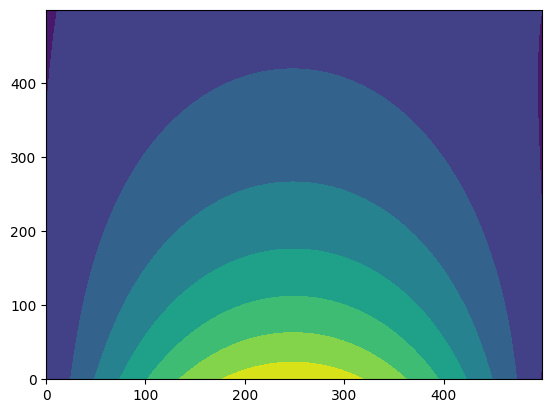

In [88]:
t = torch.linspace(0, 1, 500)
x = torch.linspace(0, 1, 500)
input = torch.cartesian_prod(t, x)
pred = model(input).detach().numpy()

plt.contourf(pred.reshape(500, 500), level = 20)

In [103]:
index = 1000

input = torch.rand((index**2, 2))

f = lambda input: torch.exp(-100 * ((input[:, 0] - 0.5)**2 + (input[:, 1] - 0.5)**2))
ic = f(input).reshape(index, index)

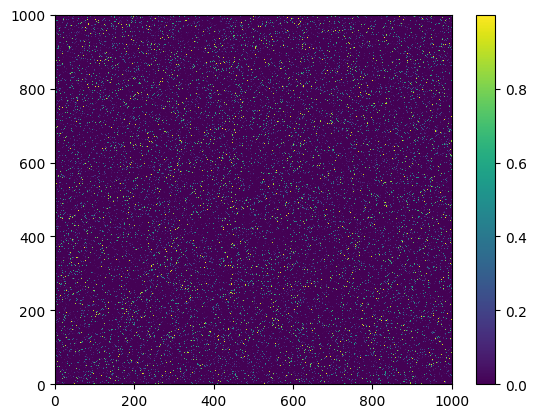

In [104]:
plt.pcolormesh(ic)
plt.colorbar()